# Layered DDPM Inpainting — Quantitative Evaluation

This notebook evaluates the layered DDPM inpainting pipeline (`improve_second_try.py`) on **20 images**
from the **MS COCO val2017** dataset, using **MNIST digit silhouettes** as masks.

**Pipeline:** For each image we erase a digit-shaped region and ask the model to reconstruct it using the
image's COCO caption as the prompt. The mask is split into concentric onion-peel layers via a
distance transform; each layer is denoised independently with DDPM. We then measure reconstruction
quality via SSIM, PSNR, and LPIPS on the **masked region only** and display the 10 best and 10 worst results.

**Mask convention (`improve_second_try.py`):** `1 = keep, 0 = inpaint`.

In [1]:
import sys, os, json
import numpy as np
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_fn
from tqdm.auto import tqdm

try:
    import lpips
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lpips"])
    import lpips

# ---- Config ----
N_IMAGES             = 20       # Total images to evaluate
IMAGE_SIZE           = (512, 512)
SEED                 = 42
NUM_LAYERS           = 2
STEPS_PER_LAYER      = 25       # Broadcast to all layers
GUIDANCE_SCALE       = 7.5      # Broadcast to all layers
DATA_ROOT            = "./data"
RESULTS_DIR          = "./eval_results_layered"
CHECKPOINT_PATH      = os.path.join(RESULTS_DIR, "checkpoint.json")

COCO_ROOT      = os.path.join(DATA_ROOT, "coco")
COCO_IMG_DIR   = os.path.join(COCO_ROOT, "val2017")
COCO_ANN_FILE  = os.path.join(COCO_ROOT, "annotations", "captions_val2017.json")
COCO_INST_FILE = os.path.join(COCO_ROOT, "annotations", "instances_val2017.json")

os.makedirs(os.path.join(RESULTS_DIR, "originals"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "inpainted"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "masks"), exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Config: N_IMAGES={N_IMAGES}, SIZE={IMAGE_SIZE}, NUM_LAYERS={NUM_LAYERS}, "
      f"STEPS_PER_LAYER={STEPS_PER_LAYER}, GUIDANCE={GUIDANCE_SCALE}")

/Users/roeikasuss/miniconda3/envs/inpainting-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config: N_IMAGES=20, SIZE=(512, 512), NUM_LAYERS=2, STEPS_PER_LAYER=25, GUIDANCE=7.5


In [2]:
import urllib.request
import zipfile

# ---- reporthook for download progress ----
_pbar = None

def reporthook(block_num, block_size, total_size):
    global _pbar
    if _pbar is None:
        _pbar = tqdm(total=total_size, unit="B", unit_scale=True, unit_divisor=1024)
    downloaded = block_num * block_size
    _pbar.n = min(downloaded, total_size)
    _pbar.refresh()
    if downloaded >= total_size:
        _pbar.close()
        _pbar = None

# ---- Download COCO val2017 images (~1 GB) ----
os.makedirs(COCO_ROOT, exist_ok=True)

IMG_URL = "http://images.cocodataset.org/zips/val2017.zip"
ANN_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

if not os.path.isdir(COCO_IMG_DIR):
    img_zip = os.path.join(COCO_ROOT, "val2017.zip")
    print("Downloading COCO val2017 images (~1 GB)...")
    urllib.request.urlretrieve(IMG_URL, img_zip, reporthook)
    print("Extracting images...")
    with zipfile.ZipFile(img_zip) as z:
        z.extractall(COCO_ROOT)
    os.remove(img_zip)
    print("Done.")
else:
    print(f"COCO images already present: {COCO_IMG_DIR}")

# ---- Download COCO annotations (~240 MB) ----
if not os.path.exists(COCO_ANN_FILE):
    ann_zip = os.path.join(COCO_ROOT, "annotations_trainval2017.zip")
    print("Downloading COCO annotations (~240 MB)...")
    urllib.request.urlretrieve(ANN_URL, ann_zip, reporthook)
    print("Extracting annotations...")
    with zipfile.ZipFile(ann_zip) as z:
        z.extractall(COCO_ROOT)
    os.remove(ann_zip)
    print("Done.")
else:
    print(f"COCO annotations already present: {COCO_ANN_FILE}")

# ---- Load captions JSON → build img_id -> [captions] mapping ----
with open(COCO_ANN_FILE, "r") as f:
    coco_data = json.load(f)

coco_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

coco_captions = {}
for ann in coco_data["annotations"]:
    img_id = ann["image_id"]
    coco_captions.setdefault(img_id, []).append(ann["caption"])

# ---- Build set of image IDs to exclude (person, animal, sports, food) ----
# These supercategories produce images dominated by foreground subjects rather
# than buildings, rooms, scenery, nature, or street/vehicle scenes.
EXCLUDED_SUPERCATEGORIES = {"person", "animal", "sports", "food"}

with open(COCO_INST_FILE, "r") as f:
    inst_data = json.load(f)

excluded_cat_ids = {
    c["id"] for c in inst_data["categories"]
    if c["supercategory"] in EXCLUDED_SUPERCATEGORIES
}
excluded_image_ids = {
    a["image_id"] for a in inst_data["annotations"]
    if a["category_id"] in excluded_cat_ids
}
print(f"Images excluded (person/animal/sports/food): "
      f"{len(excluded_image_ids)} / {len(coco_id_to_filename)}")

# ---- Keep only scene/room/nature/vehicle images that have a caption and exist on disk ----
valid_ids = [
    img_id for img_id, caps in coco_captions.items()
    if img_id not in excluded_image_ids
    and os.path.exists(os.path.join(COCO_IMG_DIR, coco_id_to_filename[img_id]))
]
print(f"Scene/room/nature/vehicle images remaining: {len(valid_ids)}")

# ---- Sample N_IMAGES image IDs deterministically ----
rng = np.random.RandomState(SEED)
sampled_ids = rng.choice(valid_ids, size=N_IMAGES, replace=False).tolist()

# Build ordered list of (filename, first_caption) for the sampled images
coco_samples = [
    (coco_id_to_filename[img_id], coco_captions[img_id][0])
    for img_id in sampled_ids
]

# ---- Load MNIST (test set) ----
mnist = torchvision.datasets.MNIST(
    root=DATA_ROOT, train=False, download=True
)

# ---- Sample MNIST indices deterministically ----
mnist_indices = rng.choice(len(mnist), size=N_IMAGES, replace=False)

print(f"MNIST dataset size:  {len(mnist)}")
print(f"Sampled {N_IMAGES} scene/room/nature/vehicle image-mask pairs.")

COCO images already present: ./data/coco/val2017
COCO annotations already present: ./data/coco/annotations/captions_val2017.json
Images excluded (person/animal/sports/food): 3809 / 5000
Scene/room/nature/vehicle images remaining: 1191
MNIST dataset size:  10000
Sampled 20 scene/room/nature/vehicle image-mask pairs.


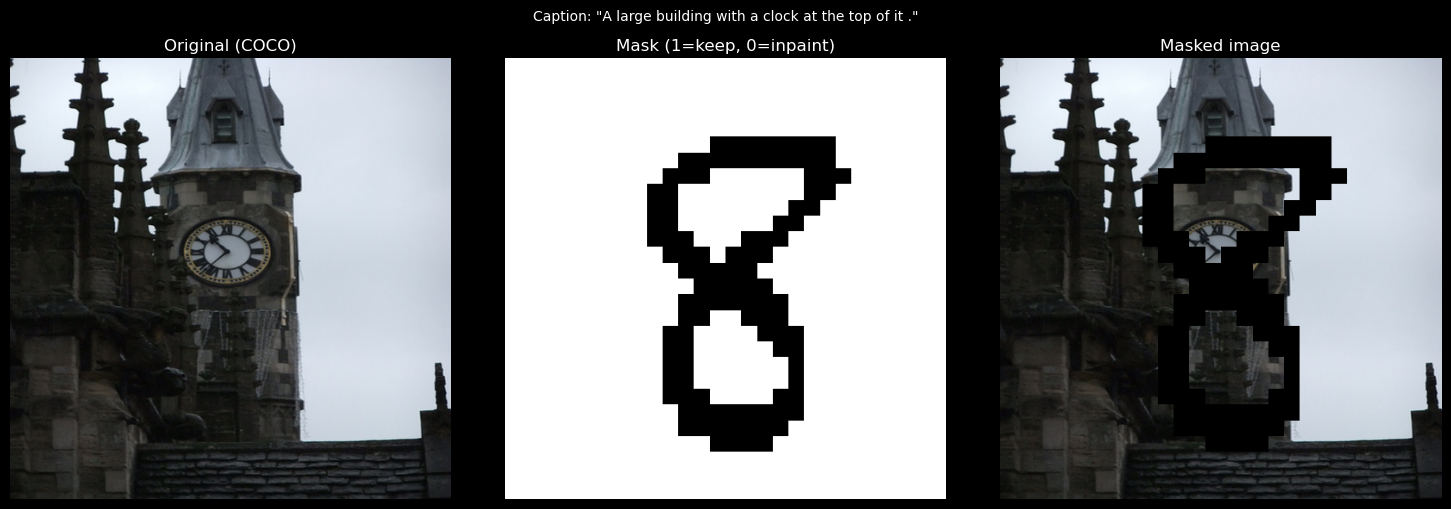

Inpainted region: 13.9% of image


In [3]:
def prepare_mnist_mask(mnist_image: Image.Image, size=IMAGE_SIZE) -> torch.Tensor:
    """
    Convert an MNIST digit image into a binary mask for improve_second_try.
    Convention: 1 = keep, 0 = inpaint.
    The digit silhouette becomes the inpainted (erased) region.

    Returns: torch.Tensor of shape (1, 1, H, W)
    """
    # Resize 28x28 -> 512x512
    mask_pil = mnist_image.resize(size, Image.NEAREST)
    mask_np = np.array(mask_pil)

    # MNIST: digit pixels are bright (>127), background is dark.
    # We INVERT: digit pixels -> 0 (inpaint), background -> 1 (keep).
    mask_binary = (mask_np <= 127).astype(np.float32)
    mask_tensor = torch.from_numpy(mask_binary).unsqueeze(0).unsqueeze(0)
    return mask_tensor


def prepare_coco_image(path: str, size=IMAGE_SIZE) -> Image.Image:
    """Load a COCO image from disk and resize to the target size."""
    return Image.open(path).convert("RGB").resize(size, Image.LANCZOS)


def apply_mask_for_display(image: Image.Image, mask_tensor: torch.Tensor) -> Image.Image:
    """Black out the inpainted region for visualization."""
    img_np = np.array(image).copy()
    mask_np = mask_tensor.squeeze().numpy()  # (H, W), 1=keep, 0=inpaint
    img_np[mask_np == 0] = 0  # black for inpainted region
    return Image.fromarray(img_np)


# ---- Sanity check: display one example ----
sample_filename, sample_caption = coco_samples[0]
sample_img = prepare_coco_image(os.path.join(COCO_IMG_DIR, sample_filename))
sample_mask = prepare_mnist_mask(mnist[mnist_indices[0]][0])
sample_masked = apply_mask_for_display(sample_img, sample_mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_img);    axes[0].set_title("Original (COCO)")
axes[1].imshow(sample_mask.squeeze(), cmap="gray"); axes[1].set_title("Mask (1=keep, 0=inpaint)")
axes[2].imshow(sample_masked); axes[2].set_title("Masked image")
for ax in axes: ax.axis("off")
plt.suptitle(f'Caption: "{sample_caption}"', fontsize=10, y=1.01)
plt.tight_layout(); plt.show()

inpaint_frac = (sample_mask == 0).float().mean().item() * 100
print(f"Inpainted region: {inpaint_frac:.1f}% of image")

In [4]:
# ---- Import model loader and inpainting function from improve_second_try.py ----
sys.path.insert(0, os.path.abspath("."))
from improve_second_try import load_layered_model, layered_ddpm_inpaint

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading model...")
pipe = load_layered_model(device)
pipe.set_progress_bar_config(disable=True)  # suppress inner per-step bar
print("Model loaded.")

/Users/roeikasuss/miniconda3/envs/inpainting-env/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Using device: mps
Loading model...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 15.15it/s]


Model loaded.


In [ ]:
# ---- Inpainting loop with disk-based resume support ----

# Check for existing checkpoint
start_idx = 0
if os.path.exists(CHECKPOINT_PATH):
    with open(CHECKPOINT_PATH, "r") as f:
        checkpoint = json.load(f)
    start_idx = checkpoint.get("completed", 0)
    print(f"Resuming from image {start_idx}/{N_IMAGES}")

for i in tqdm(range(start_idx, N_IMAGES), initial=start_idx,
              total=N_IMAGES, desc="Inpainting"):
    # Load COCO image from disk
    filename, prompt = coco_samples[i]
    img_pil = prepare_coco_image(os.path.join(COCO_IMG_DIR, filename))

    # Prepare mask
    mask_tensor = prepare_mnist_mask(mnist[mnist_indices[i]][0])

    # Run layered DDPM inpainting (prompt is the COCO caption verbatim)
    inpainted_pil = layered_ddpm_inpaint(
        pipe=pipe,
        image=img_pil,
        mask=mask_tensor,
        prompt=prompt,
        num_layers=NUM_LAYERS,
        steps_per_layer=STEPS_PER_LAYER,
        guidance_scale_per_layer=GUIDANCE_SCALE,
        seed=SEED + i,
    )

    # Save to disk
    img_pil.save(os.path.join(RESULTS_DIR, "originals", f"{i:04d}.png"))
    inpainted_pil.save(os.path.join(RESULTS_DIR, "inpainted", f"{i:04d}.png"))
    torch.save(mask_tensor, os.path.join(RESULTS_DIR, "masks", f"{i:04d}.pt"))
    with open(os.path.join(RESULTS_DIR, "originals", f"{i:04d}.json"), "w") as f:
        json.dump({"caption": prompt}, f)

    # Update checkpoint
    with open(CHECKPOINT_PATH, "w") as f:
        json.dump({"completed": i + 1, "last_prompt": prompt}, f)

print(f"Done. Inpainted {N_IMAGES} images.")

Inpainting:  25%|██▌       | 5/20 [00:52<02:37, 10.53s/it]

In [ ]:
# ---- Compute metrics on the masked (inpainted) region only ----

lpips_model = lpips.LPIPS(net="alex").to(device)
lpips_model.eval()


def compute_masked_metrics(
    original: Image.Image,
    inpainted: Image.Image,
    mask_tensor: torch.Tensor,
) -> dict:
    """
    Compute SSIM, PSNR, LPIPS only on the inpainted region.
    mask_tensor: (1,1,H,W), 1=keep, 0=inpaint.
    """
    orig_np = np.array(original).astype(np.float64)
    inp_np  = np.array(inpainted).astype(np.float64)
    mask_np = mask_tensor.squeeze().numpy()
    inpaint_mask = (mask_np == 0)

    if not inpaint_mask.any():
        return {"ssim": 1.0, "psnr": float("inf"), "lpips": 0.0}

    # ---- Bounding box of inpainted region ----
    rows = np.any(inpaint_mask, axis=1)
    cols = np.any(inpaint_mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    crop_orig = orig_np[rmin:rmax + 1, cmin:cmax + 1]
    crop_inp  = inp_np[rmin:rmax + 1, cmin:cmax + 1]

    # ---- PSNR: only on inpainted pixels ----
    masked_orig = orig_np[inpaint_mask]
    masked_inp  = inp_np[inpaint_mask]
    mse = np.mean((masked_orig - masked_inp) ** 2)
    psnr_val = 10.0 * np.log10(255.0 ** 2 / mse) if mse > 0 else float("inf")

    # ---- SSIM: on bounding-box crop ----
    min_dim = min(crop_orig.shape[0], crop_orig.shape[1])
    win_size = min(7, min_dim if min_dim % 2 == 1 else min_dim - 1)
    win_size = max(win_size, 3)

    ssim_val = ssim_fn(
        crop_orig, crop_inp,
        data_range=255.0, channel_axis=2, win_size=win_size
    )

    # ---- LPIPS: on bounding-box crop (avoids black-region artifacts) ----
    crop_orig_f = crop_orig.astype(np.float32)
    crop_inp_f  = crop_inp.astype(np.float32)

    orig_t = torch.from_numpy(crop_orig_f).permute(2, 0, 1).unsqueeze(0) / 127.5 - 1.0
    inp_t  = torch.from_numpy(crop_inp_f).permute(2, 0, 1).unsqueeze(0) / 127.5 - 1.0

    with torch.no_grad():
        lpips_val = lpips_model(orig_t.to(device), inp_t.to(device)).item()

    return {"ssim": ssim_val, "psnr": psnr_val, "lpips": lpips_val}


# ---- Load results from disk and compute metrics ----
results = []
for i in tqdm(range(N_IMAGES), desc="Computing metrics"):
    orig_path    = os.path.join(RESULTS_DIR, "originals", f"{i:04d}.png")
    inp_path     = os.path.join(RESULTS_DIR, "inpainted", f"{i:04d}.png")
    mask_path    = os.path.join(RESULTS_DIR, "masks",     f"{i:04d}.pt")
    caption_path = os.path.join(RESULTS_DIR, "originals", f"{i:04d}.json")

    if not all(os.path.exists(p) for p in [orig_path, inp_path, mask_path]):
        print(f"Stopping at image {i} (files not found). Run inpainting loop first.")
        break

    orig_img = Image.open(orig_path)
    inp_img  = Image.open(inp_path)
    mask_t   = torch.load(mask_path, weights_only=True)

    caption = ""
    if os.path.exists(caption_path):
        with open(caption_path) as f:
            caption = json.load(f).get("caption", "")

    metrics = compute_masked_metrics(orig_img, inp_img, mask_t)
    results.append({
        "idx": i, "original": orig_img, "inpainted": inp_img,
        "mask": mask_t, "caption": caption, **metrics
    })

print(f"Computed metrics for {len(results)} images.")

In [ ]:
# ---- Aggregate statistics and KDE distributions ----
from scipy.stats import gaussian_kde

ssim_vals  = np.array([r["ssim"]  for r in results])
psnr_vals  = np.array([r["psnr"]  for r in results])
lpips_vals = np.array([r["lpips"] for r in results])

print("=" * 55)
print(f"Results over {len(results)} images (inpainted region only)")
print("=" * 55)
print(f"{'Metric':<10} {'Mean':>10} {'Median':>10} {'Std':>10}")
print("-" * 55)
print(f"{'SSIM':<10} {ssim_vals.mean():>10.4f} {np.median(ssim_vals):>10.4f} {ssim_vals.std():>10.4f}")
print(f"{'PSNR':<10} {psnr_vals.mean():>10.2f} {np.median(psnr_vals):>10.2f} {psnr_vals.std():>10.2f}")
print(f"{'LPIPS':<10} {lpips_vals.mean():>10.4f} {np.median(lpips_vals):>10.4f} {lpips_vals.std():>10.4f}")
print("=" * 55)

def plot_kde(ax, values, color, xlabel, title):
    kde = gaussian_kde(values, bw_method="scott")
    x = np.linspace(values.min() - 0.05 * np.ptp(values),
                    values.max() + 0.05 * np.ptp(values), 500)
    y = kde(x)
    ax.plot(x, y, color=color, linewidth=2)
    ax.fill_between(x, y, alpha=0.25, color=color)
    ax.axvline(values.mean(),   color=color, linestyle="--", linewidth=1.2, label=f"mean={values.mean():.3f}")
    ax.axvline(np.median(values), color="black", linestyle=":",  linewidth=1.2, label=f"median={np.median(values):.3f}")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
plot_kde(axes[0], ssim_vals,  "steelblue",  "SSIM",           "SSIM Distribution")
plot_kde(axes[1], psnr_vals,  "darkorange", "PSNR (dB)",      "PSNR Distribution")
plot_kde(axes[2], lpips_vals, "seagreen",   "LPIPS (Lower is better)", "LPIPS Distribution")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "metric_distributions.png"), dpi=150)
plt.show()

In [ ]:
# ---- Top 10 BEST (highest SSIM = most similar reconstruction) ----
sorted_by_ssim = sorted(results, key=lambda r: r["ssim"], reverse=True)
top10_best = sorted_by_ssim[:10]

fig, axes = plt.subplots(10, 3, figsize=(15, 50))
fig.suptitle("Top 10 BEST Inpainting Results (highest SSIM)", fontsize=16, y=1.0)

for row, r in enumerate(top10_best):
    masked_vis = apply_mask_for_display(r["original"], r["mask"])

    axes[row, 0].imshow(r["original"])
    axes[row, 0].set_title("Original" if row == 0 else "")
    axes[row, 0].set_ylabel(
        f"#{r['idx']}\nSSIM={r['ssim']:.3f}\nPSNR={r['psnr']:.1f}\nLPIPS={r['lpips']:.3f}",
        fontsize=9, rotation=0, labelpad=70, va="center"
    )

    axes[row, 1].imshow(masked_vis)
    axes[row, 1].set_title("Masked" if row == 0 else "")
    axes[row, 1].set_xlabel(f'"{ r["caption"]}"', fontsize=8, labelpad=6)

    axes[row, 2].imshow(r["inpainted"])
    axes[row, 2].set_title("Inpainted" if row == 0 else "")

    for col in range(3):
        axes[row, col].axis("off")
    # Re-enable x-axis label on the masked column (axis("off") hides it)
    axes[row, 1].xaxis.set_visible(True)
    axes[row, 1].tick_params(bottom=False, labelbottom=True)
    axes[row, 1].set_xticks([])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "top10_best.png"), dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# ---- Top 10 WORST (lowest SSIM = least similar reconstruction) ----
top10_worst = sorted_by_ssim[-10:]

fig, axes = plt.subplots(10, 3, figsize=(15, 50))
fig.suptitle("Top 10 WORST Inpainting Results (lowest SSIM)", fontsize=16, y=1.0)

for row, r in enumerate(top10_worst):
    masked_vis = apply_mask_for_display(r["original"], r["mask"])

    axes[row, 0].imshow(r["original"])
    axes[row, 0].set_title("Original" if row == 0 else "")
    axes[row, 0].set_ylabel(
        f"#{r['idx']}\nSSIM={r['ssim']:.3f}\nPSNR={r['psnr']:.1f}\nLPIPS={r['lpips']:.3f}",
        fontsize=9, rotation=0, labelpad=70, va="center"
    )

    axes[row, 1].imshow(masked_vis)
    axes[row, 1].set_title("Masked" if row == 0 else "")
    axes[row, 1].set_xlabel(f'"{ r["caption"]}"', fontsize=8, labelpad=6)

    axes[row, 2].imshow(r["inpainted"])
    axes[row, 2].set_title("Inpainted" if row == 0 else "")

    for col in range(3):
        axes[row, col].axis("off")
    # Re-enable x-axis label on the masked column (axis("off") hides it)
    axes[row, 1].xaxis.set_visible(True)
    axes[row, 1].tick_params(bottom=False, labelbottom=True)
    axes[row, 1].set_xticks([])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "top10_worst.png"), dpi=150, bbox_inches="tight")
plt.show()